In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1>BiLSTM1</h1>

In [11]:
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               141312    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 158150 (617.77 KB)
Trainable params: 158150 (617.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 9s 54ms/step - loss: 1.2068 - accuracy: 0.4876 - val_loss: 0.9560 - val_accuracy: 0.6111
Epoch 2/10
58/58 [==============================] - 2s 41ms/step - loss: 0.8213 - accuracy: 0.6629 - val_loss: 0.8810 - val_accuracy: 0.5712
Epoch 3/10
58/58 [==============================] - 2s 36ms/step - loss: 0.7028 - accuracy: 0.7176 - val_loss: 0.6069 - val_accuracy: 0.7842
Epoch 4/10
58/58 [==============================] - 2s 42ms/step - loss: 0.6001 - accuracy: 0.7742 - val_loss: 0.3898 - val_accuracy: 0.8554
Epoch 5/10
58/58 [==============================] - 2s 37ms/step - loss: 0.7618 - accuracy: 0.7327 - val_loss: 0.6996 - val_accuracy: 0.7448
Epoch 6/10
58/58 [==============================] - 2s 33ms/step - loss: 0.5304 - accuracy: 0.8108 - val_loss: 0.4843 - val_accuracy: 0.7901
Epoch 7/10
58/58 [==============================] - 2s 42ms/step - loss: 0.6461 - accuracy: 0.6986 - val_loss: 0.5835 - val_accuracy: 0.7380
Epoch 8/10
58

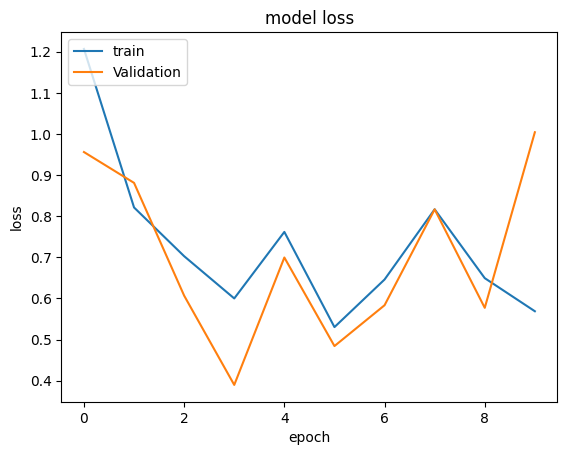

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

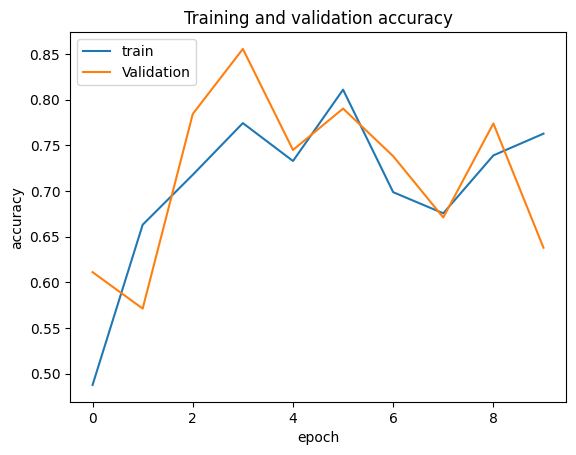

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 11ms/step
[[304 108  32   0  52   0]
 [ 63 270  53   0  85   0]
 [100   7 301   0  12   0]
 [165   4  21  16  89 196]
 [ 68  48  13   0 391  12]
 [  0  26   0  10  27 474]]
0.5958601968103155
0.5509524188400546
              precision    recall  f1-score   support

           0       0.43      0.61      0.51       496
           1       0.58      0.57      0.58       471
           2       0.72      0.72      0.72       420
           3       0.62      0.03      0.06       491
           4       0.60      0.73      0.66       532
           5       0.70      0.88      0.78       537

    accuracy                           0.60      2947
   macro avg       0.61      0.59      0.55      2947
weighted avg       0.61      0.60      0.55      2947



<Axes: >

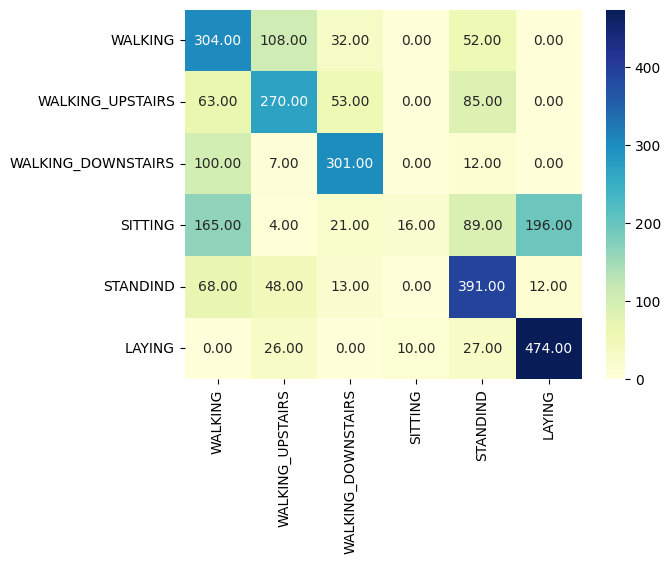

In [15]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>BiLSTM2</h1>

In [17]:
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 6)                

In [18]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 15s 96ms/step - loss: 1.0446 - accuracy: 0.5507 - val_loss: 0.6716 - val_accuracy: 0.7298
Epoch 2/10
58/58 [==============================] - 3s 55ms/step - loss: 0.5727 - accuracy: 0.7629 - val_loss: 0.4116 - val_accuracy: 0.8395
Epoch 3/10
58/58 [==============================] - 4s 72ms/step - loss: 0.3675 - accuracy: 0.8640 - val_loss: 0.3305 - val_accuracy: 0.8708
Epoch 4/10
58/58 [==============================] - 3s 47ms/step - loss: 0.2782 - accuracy: 0.8969 - val_loss: 0.2197 - val_accuracy: 0.9184
Epoch 5/10
58/58 [==============================] - 3s 47ms/step - loss: 0.2246 - accuracy: 0.9221 - val_loss: 0.2418 - val_accuracy: 0.9007
Epoch 6/10
58/58 [==============================] - 3s 51ms/step - loss: 0.2102 - accuracy: 0.9157 - val_loss: 0.1682 - val_accuracy: 0.9352
Epoch 7/10
58/58 [==============================] - 3s 61ms/step - loss: 0.1689 - accuracy: 0.9338 - val_loss: 0.1250 - val_accuracy: 0.9538
Epoch 8/10
5

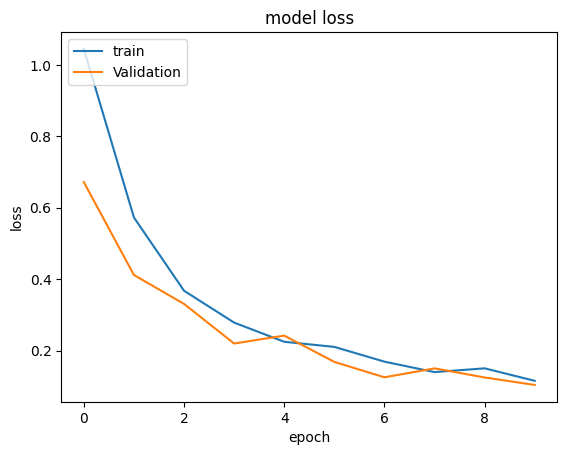

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

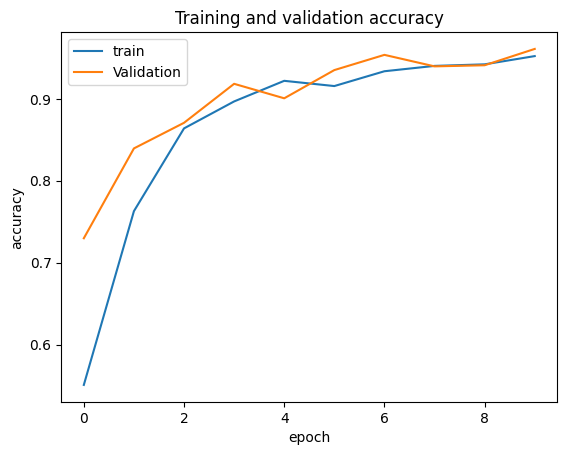

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 13ms/step
[[452  13  31   0   0   0]
 [  5 432  34   0   0   0]
 [  0   0 420   0   0   0]
 [  0  25   0 400  66   0]
 [  1   1   0 116 414   0]
 [  0  27   0   0   0 510]]
0.8917543264336614
0.8918545634394454
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       496
           1       0.87      0.92      0.89       471
           2       0.87      1.00      0.93       420
           3       0.78      0.81      0.79       491
           4       0.86      0.78      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.90      0.89      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

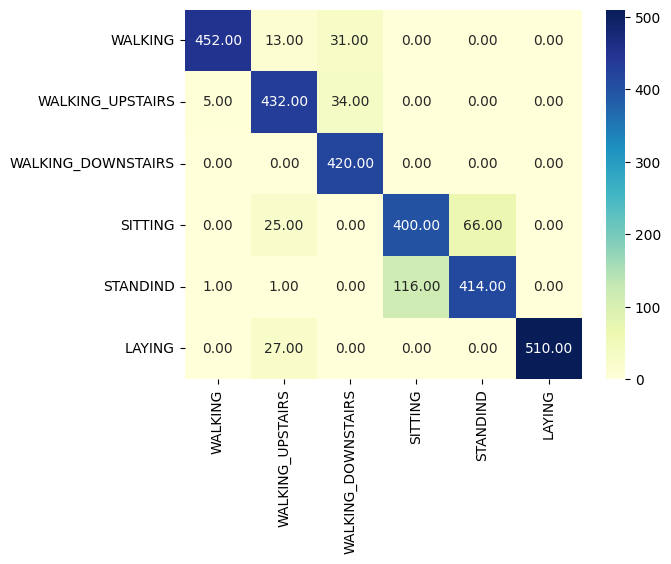

In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>BiLSTM3</h1>

In [22]:
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 128, 256)          394240    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                      

In [23]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 24s 142ms/step - loss: 1.0270 - accuracy: 0.5569 - val_loss: 0.6648 - val_accuracy: 0.7230
Epoch 2/10
58/58 [==============================] - 4s 76ms/step - loss: 0.5800 - accuracy: 0.7598 - val_loss: 0.4390 - val_accuracy: 0.8391
Epoch 3/10
58/58 [==============================] - 4s 73ms/step - loss: 0.4408 - accuracy: 0.8351 - val_loss: 0.3837 - val_accuracy: 0.8640
Epoch 4/10
58/58 [==============================] - 4s 74ms/step - loss: 0.3731 - accuracy: 0.8641 - val_loss: 0.2458 - val_accuracy: 0.9175
Epoch 5/10
58/58 [==============================] - 4s 74ms/step - loss: 0.2690 - accuracy: 0.9007 - val_loss: 0.2611 - val_accuracy: 0.9066
Epoch 6/10
58/58 [==============================] - 5s 80ms/step - loss: 0.2271 - accuracy: 0.9163 - val_loss: 0.1678 - val_accuracy: 0.9402
Epoch 7/10
58/58 [==============================] - 5s 83ms/step - loss: 0.1526 - accuracy: 0.9404 - val_loss: 0.1752 - val_accuracy: 0.9252
Epoch 8/10


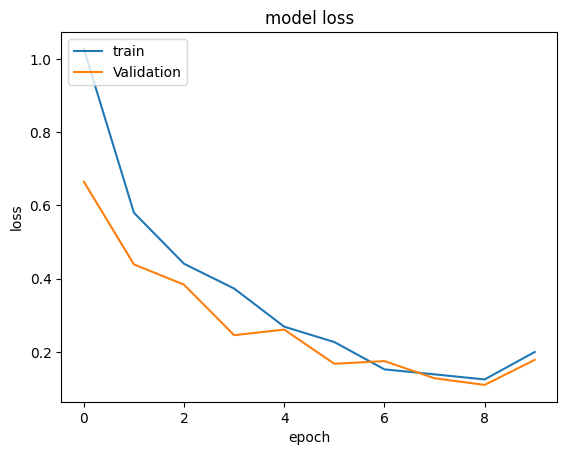

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

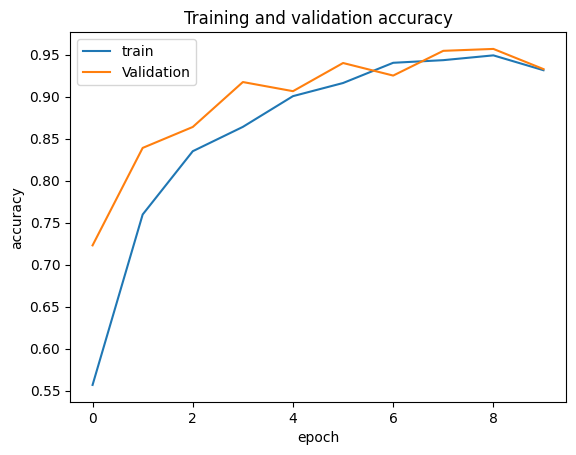

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 4s 16ms/step
[[407  21  55   0  13   0]
 [  5 419  43   0   4   0]
 [ 22  24 369   0   5   0]
 [  0   9   0 415  67   0]
 [  1   4   0  78 449   0]
 [  0  27   0   0   0 510]]
0.8717339667458432
0.8726581852263893
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       496
           1       0.83      0.89      0.86       471
           2       0.79      0.88      0.83       420
           3       0.84      0.85      0.84       491
           4       0.83      0.84      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.88      0.87      0.87      2947



<Axes: >

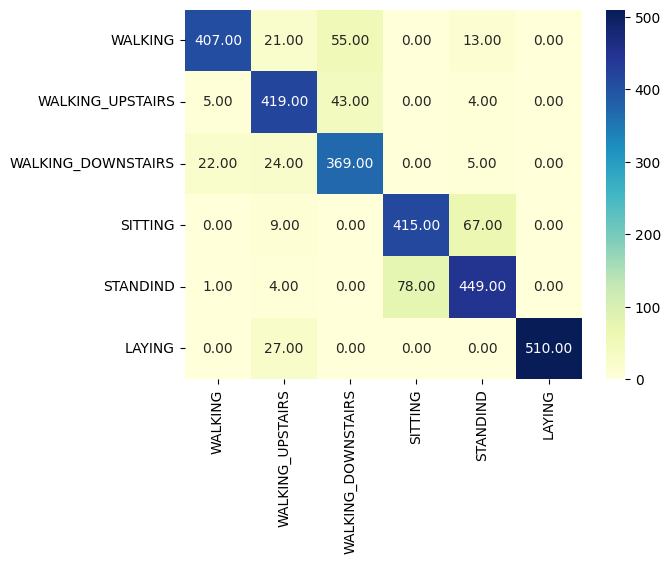

In [26]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>BiLSTM4</h1>

In [27]:
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 128, 256)          394240    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 128, 256)          394240    
 onal)                                                           
                                                      

In [28]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 23s 171ms/step - loss: 1.0467 - accuracy: 0.5486 - val_loss: 0.7115 - val_accuracy: 0.6936
Epoch 2/10
58/58 [==============================] - 6s 99ms/step - loss: 0.6261 - accuracy: 0.7273 - val_loss: 0.4755 - val_accuracy: 0.8060
Epoch 3/10
58/58 [==============================] - 6s 104ms/step - loss: 0.4650 - accuracy: 0.8050 - val_loss: 0.3793 - val_accuracy: 0.8586
Epoch 4/10
58/58 [==============================] - 6s 96ms/step - loss: 0.4062 - accuracy: 0.8481 - val_loss: 0.2650 - val_accuracy: 0.9080
Epoch 5/10
58/58 [==============================] - 6s 96ms/step - loss: 0.2251 - accuracy: 0.9173 - val_loss: 0.1502 - val_accuracy: 0.9501
Epoch 6/10
58/58 [==============================] - 6s 97ms/step - loss: 0.1668 - accuracy: 0.9342 - val_loss: 0.1650 - val_accuracy: 0.9279
Epoch 7/10
58/58 [==============================] - 5s 94ms/step - loss: 0.1745 - accuracy: 0.9344 - val_loss: 0.1419 - val_accuracy: 0.9461
Epoch 8/10

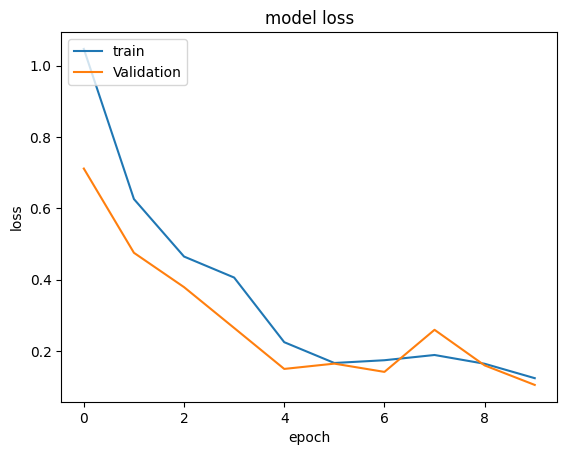

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

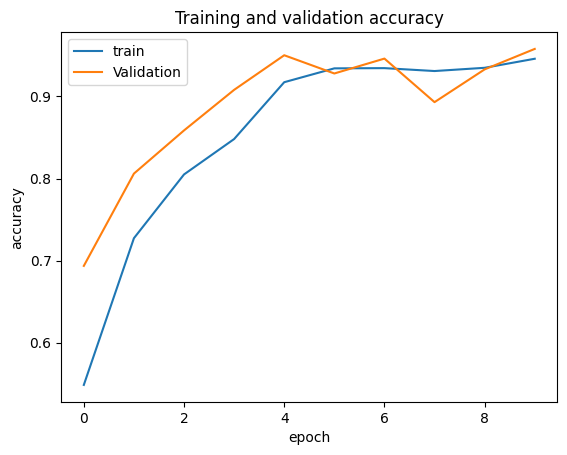

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 5s 20ms/step
[[441  26  29   0   0   0]
 [ 13 434  24   0   0   0]
 [  0   6 414   0   0   0]
 [  0  20   1 376  89   5]
 [  1   2   0  87 442   0]
 [  0  15   0   0   0 522]]
0.8920936545639634
0.8916637162527096
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       496
           1       0.86      0.92      0.89       471
           2       0.88      0.99      0.93       420
           3       0.81      0.77      0.79       491
           4       0.83      0.83      0.83       532
           5       0.99      0.97      0.98       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

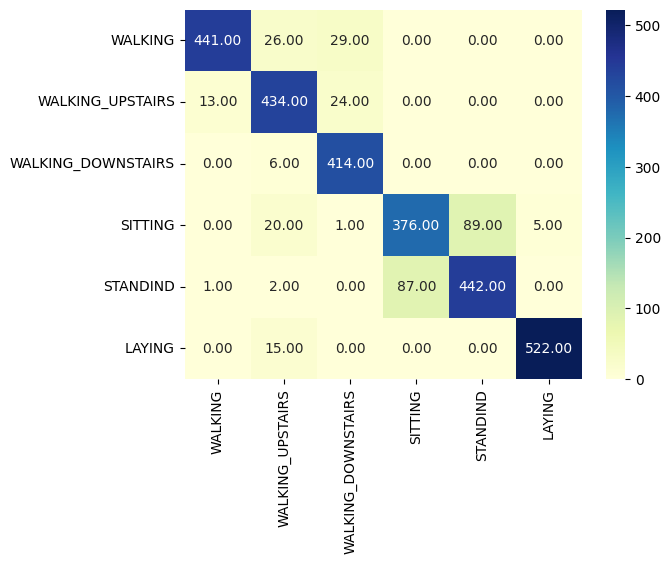

In [31]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')